In [1]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt

from operator import itemgetter  

from sklearn.metrics import plot_confusion_matrix

import os

# Evaluation

## Last-layer features

In [18]:
last_features_class1_path = "./output/went_icu_sel_proc_aug_last.csv" #"./output/1-2_icu_18feat.csv"
last_features_class2_path = "./output/not_went_icu_sel_proc_aug_last.csv" #"./output/1-2_not_icu_18feat.csv"

In [19]:
last_features_class1 = pd.read_csv(last_features_class1_path)
last_features_class1 = last_features_class1.iloc[:,1:].to_numpy()

print(last_features_class1.shape)

(455, 18)


In [20]:
last_features_class2 = pd.read_csv(last_features_class2_path)
last_features_class2 = last_features_class2.iloc[:,1:].to_numpy()

print(last_features_class2.shape)

(585, 18)


In [7]:
#concatenate
last_features = np.concatenate((last_features_class1, last_features_class2), axis=0)
print(last_features.shape)

#normalize
last_features_norm = (last_features - last_features.mean(axis=0)) / last_features.std(axis=0)  
print(last_features_norm.shape)

(1040, 18)
(1040, 18)


In [8]:
feature_name_file_path = './output/features_names.txt'

feature_names = []
with open(feature_name_file_path,'r') as f:
    for line in f:
        feature_names.append(str(line))
        
print(len(feature_names))
print(feature_names[0:5])

18
['Atelectasis\n', 'Cardiomegaly\n', 'Consolidation\n', 'Edema\n', 'Effusion\n']


In [9]:
Y = np.zeros((last_features.shape[0],))
Y[0:last_features_class1.shape[0],] = 1
Y.shape

(1040,)

In [11]:
features = last_features_norm
features_names_ = feature_names

max_depth_tree = 4
min_samples_leaf = 20
clf_18 = tree.DecisionTreeClassifier(class_weight={0:1,1:1},max_depth=max_depth_tree, min_samples_leaf=min_samples_leaf)

#class_weight={0:10,1:1}

in_training_loss = True
train_test_ratio = 0.2

if in_training_loss:
    clf_18 = clf_18.fit(features, Y)
    y_pred = clf_18.predict(features)

    print(confusion_matrix(Y, y_pred))
    print(classification_report(Y, y_pred))

    feature_lst=[i for i in clf_18.tree_.feature if i != -2]

    print('features =', feature_lst)
    print('features name=', list(itemgetter(*feature_lst)(features_names_)))

else:
  X_train, X_test, y_train, y_test = \
  train_test_split(features, Y, test_size=train_test_ratio)

  clf_18 = clf_18.fit(X_train, y_train)
  y_pred = clf_18.predict(X_test)

  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))



[[528  57]
 [154 301]]
              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83       585
         1.0       0.84      0.66      0.74       455

    accuracy                           0.80      1040
   macro avg       0.81      0.78      0.79      1040
weighted avg       0.80      0.80      0.79      1040

features = [4, 2, 8, 12, 1, 3, 17, 12, 7]
features name= ['Effusion\n', 'Consolidation\n', 'Fracture\n', 'Lung Opacity\n', 'Cardiomegaly\n', 'Edema\n', 'Pneumothorax\n', 'Lung Opacity\n', 'Fibrosis\n']


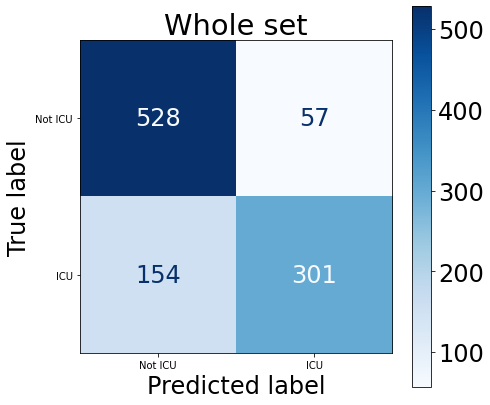

In [12]:
fig, ax = plt.subplots(figsize=(7,7))
plt.rcParams.update({'font.size': 24})

disp = plot_confusion_matrix(clf_18, features, Y,
                             display_labels=['Not ICU','ICU'],
                             cmap=plt.cm.Blues,
                             ax=ax)
disp.ax_.set_title('Whole set')

label_font = {'size':'24'}  # Adjust to fit
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);



[Text(669.6, 489.24, 'X[4] <= 0.893\ngini = 0.492\nsamples = 100.0%\nvalue = [0.562, 0.438]'),
 Text(372.0, 380.52000000000004, 'X[2] <= -0.67\ngini = 0.431\nsamples = 71.2%\nvalue = [0.686, 0.314]'),
 Text(148.8, 271.8, 'X[8] <= -1.363\ngini = 0.486\nsamples = 15.2%\nvalue = [0.418, 0.582]'),
 Text(74.4, 163.08000000000004, 'gini = 0.234\nsamples = 3.6%\nvalue = [0.865, 0.135]'),
 Text(223.20000000000002, 163.08000000000004, 'X[12] <= -0.68\ngini = 0.404\nsamples = 11.6%\nvalue = [0.281, 0.719]'),
 Text(148.8, 54.360000000000014, 'gini = 0.233\nsamples = 8.6%\nvalue = [0.135, 0.865]'),
 Text(297.6, 54.360000000000014, 'gini = 0.43\nsamples = 3.1%\nvalue = [0.688, 0.312]'),
 Text(595.2, 271.8, 'X[1] <= 1.554\ngini = 0.367\nsamples = 56.1%\nvalue = [0.758, 0.242]'),
 Text(520.8000000000001, 163.08000000000004, 'X[3] <= -0.706\ngini = 0.333\nsamples = 53.4%\nvalue = [0.789, 0.211]'),
 Text(446.40000000000003, 54.360000000000014, 'gini = 0.485\nsamples = 10.5%\nvalue = [0.587, 0.413]'),
 

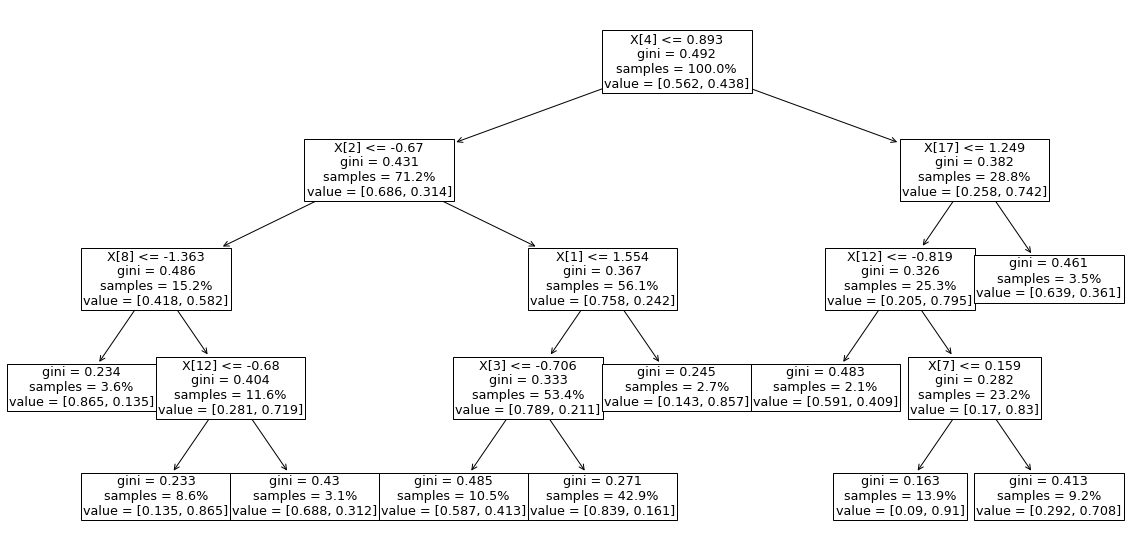

In [13]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf_18, proportion=True) 

### Cross-val

In [15]:
# cross-validation

from sklearn.model_selection import cross_val_score, cross_val_predict

cv_scores = cross_val_predict(clf_18, features, Y, cv=400)

print(confusion_matrix(Y, cv_scores))
print(classification_report(Y, cv_scores))

[[518  67]
 [163 292]]
              precision    recall  f1-score   support

         0.0       0.76      0.89      0.82       585
         1.0       0.81      0.64      0.72       455

    accuracy                           0.78      1040
   macro avg       0.79      0.76      0.77      1040
weighted avg       0.78      0.78      0.77      1040



## Mid-layer features

In [74]:
mid_features_class1_path = "./output/1-2_icu_1024feat.csv"
mid_features_class2_path = "./output/1-2_not_icu_1024feat.csv"

In [75]:
mid_features_class1 = pd.read_csv(mid_features_class1_path)
mid_features_class1 = mid_features_class1.iloc[:,1:].to_numpy()

print(mid_features_class1.shape)

(35, 1024)


In [76]:
mid_features_class2 = pd.read_csv(mid_features_class2_path)
mid_features_class2 = mid_features_class2.iloc[:,1:].to_numpy()

print(mid_features_class2.shape)

(65, 1024)


In [77]:
# concatenate
mid_features = np.concatenate((mid_features_class1, mid_features_class2), axis=0)
print(mid_features.shape)

#normalize
mid_features_norm = (mid_features - mid_features.mean(axis=0)) / mid_features.std(axis=0)  
mid_features_norm[np.isnan(mid_features_norm)] = 0
print(mid_features_norm.shape)

(100, 1024)
(100, 1024)


/home/barth/anaconda3/envs/covid_test/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [78]:
features = mid_features_norm

max_depth_tree = 3
min_samples_leaf = 15
clf = tree.DecisionTreeClassifier(class_weight={0:1,1:1},max_depth=max_depth_tree, min_samples_leaf=min_samples_leaf)

in_training_loss = True
train_test_ratio = 0.2

if in_training_loss:
    clf = clf.fit(features, Y)
    y_pred = clf.predict(features)

    print(confusion_matrix(Y, y_pred))
    print(classification_report(Y, y_pred))

    feature_lst=[i for i in clf.tree_.feature if i != -2]
    print(len(feature_lst),'features')

else:
  X_train, X_test, y_train, y_test = \
  train_test_split(features, Y, test_size=train_test_ratio)

  clf = clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))

[[65  0]
 [15 20]]
              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90        65
         1.0       1.00      0.57      0.73        35

    accuracy                           0.85       100
   macro avg       0.91      0.79      0.81       100
weighted avg       0.88      0.85      0.84       100

4 features


[Text(558.0, 475.65000000000003, 'X[528] <= -0.519\ngini = 0.455\nsamples = 100.0%\nvalue = [0.65, 0.35]'),
 Text(279.0, 339.75, 'X[908] <= -0.164\ngini = 0.388\nsamples = 38.0%\nvalue = [0.263, 0.737]'),
 Text(139.5, 203.85000000000002, 'gini = 0.494\nsamples = 18.0%\nvalue = [0.556, 0.444]'),
 Text(418.5, 203.85000000000002, 'gini = 0.0\nsamples = 20.0%\nvalue = [0.0, 1.0]'),
 Text(837.0, 339.75, 'X[335] <= 0.354\ngini = 0.2\nsamples = 62.0%\nvalue = [0.887, 0.113]'),
 Text(697.5, 203.85000000000002, 'X[561] <= 0.224\ngini = 0.042\nsamples = 47.0%\nvalue = [0.979, 0.021]'),
 Text(558.0, 67.94999999999999, 'gini = 0.0\nsamples = 32.0%\nvalue = [1.0, 0.0]'),
 Text(837.0, 67.94999999999999, 'gini = 0.124\nsamples = 15.0%\nvalue = [0.933, 0.067]'),
 Text(976.5, 203.85000000000002, 'gini = 0.48\nsamples = 15.0%\nvalue = [0.6, 0.4]')]

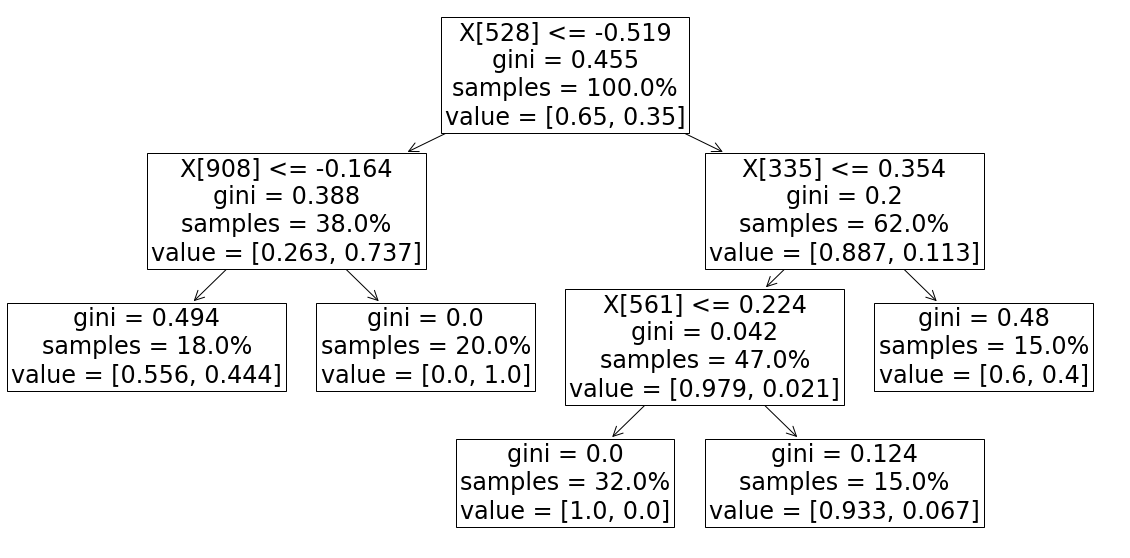

In [79]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf, proportion=True) 

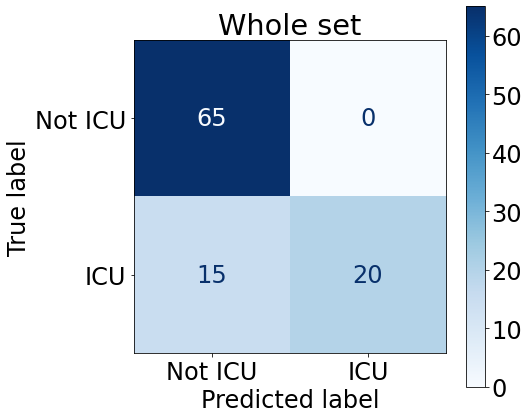

In [80]:
fig, ax = plt.subplots(figsize=(7,7))
plt.rcParams.update({'font.size': 24})

disp = plot_confusion_matrix(clf, features, Y,
                             display_labels=['Not ICU','ICU'],
                             cmap=plt.cm.Blues,
                             ax=ax)
disp.ax_.set_title('Whole set')

label_font = {'size':'24'}  # Adjust to fit
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);

### Cross-val

In [81]:
# cross-validation

from sklearn.model_selection import cross_val_score, cross_val_predict

cv_scores = cross_val_predict(clf, features, Y, cv=35)

print(confusion_matrix(Y, cv_scores))
print(classification_report(Y, cv_scores))

[[60  5]
 [16 19]]
              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85        65
         1.0       0.79      0.54      0.64        35

    accuracy                           0.79       100
   macro avg       0.79      0.73      0.75       100
weighted avg       0.79      0.79      0.78       100



## Heatmap features

In [50]:
heatmaps_features_class1_path = "./output/went_icu_sel_proc_heatmap_feat.csv"

heatmaps_features_class2_path = "./output/not_went_icu_sel_proc_heatmap_feat.csv"

In [51]:
heatmaps_features_class1 = pd.read_csv(heatmaps_features_class1_path)
heatmaps_features_class1 = heatmaps_features_class1.iloc[:,1:].to_numpy()

print(heatmaps_features_class1.shape)

(455, 396)


In [52]:
heatmaps_features_class2 = pd.read_csv(heatmaps_features_class2_path)
heatmaps_features_class2 = heatmaps_features_class2.iloc[:,1:].to_numpy()

print(heatmaps_features_class2.shape)

(585, 396)


In [53]:
#concatenate
heatmaps_features = np.concatenate((heatmaps_features_class1, heatmaps_features_class2), axis=0)
print(heatmaps_features.shape)

#normalize
heatmaps_features_norm = (heatmaps_features - heatmaps_features.mean(axis=0)) / heatmaps_features.std(axis=0)  
print(heatmaps_features_norm.shape)

(1040, 396)
(1040, 396)


In [54]:
feature_name_heatmap_path = './output/features_names_heatmap.txt'

feature_names_heatmaps = []
with open(feature_name_heatmap_path,'r') as f:
    for line in f:
        feature_names_heatmaps.append(str(line))
        
print(len(feature_names_heatmaps))
print(feature_names_heatmaps[0:5])

396
['Atelectasis_whole_image_entropy\n', 'Atelectasis_whole_image_energy\n', 'Atelectasis_long1_entropy\n', 'Atelectasis_long1_energy\n', 'Atelectasis_long2_entropy\n']


In [55]:
idx_with_quad = []

for i in range(len(feature_names_heatmaps)):
    if ('long' in feature_names_heatmaps[i]) or ('trans' in feature_names_heatmaps[i]):
        idx_with_quad.append(i)

print(len(idx_with_quad))

#heatmaps_features_no_quad = np.delete(heatmaps_features, idx_with_quad, 1)
heatmaps_features_no_quad = heatmaps_features[:,idx_with_quad]
#data_test = np.delete(data_test, idx_with_quad, 1)

print(heatmaps_features_no_quad.shape)

#print(len(feature_names))

feature_names_heatmap_no_quad = [i for i in feature_names_heatmaps if ('long' in i) or ('trans' in i)]

print(len(feature_names_heatmap_no_quad))

heatmaps_features=heatmaps_features_no_quad

heatmaps_features_norm = (heatmaps_features - heatmaps_features.mean(axis=0)) / heatmaps_features.std(axis=0)  
print(heatmaps_features_norm.shape)

feature_names_heatmaps = feature_names_heatmap_no_quad

144
(1040, 144)
144
(1040, 144)


In [56]:
# Filter only entropy (reject energy)

heatmaps_features_norm = heatmaps_features_norm[:,np.arange(0,len(feature_names_heatmaps),2,)]
feature_names_heatmaps = [i for i in feature_names_heatmaps if 'entropy' in i]

In [57]:
features = heatmaps_features_norm
features_names_ = feature_names_heatmaps# feature_names_heatmaps

max_depth_tree = 3
min_samples_leaf = 20
clf = tree.DecisionTreeClassifier(class_weight={0:1,1:1},max_depth=max_depth_tree, min_samples_leaf=min_samples_leaf)

#class_weight={0:10,1:1}

in_training_loss = True
train_test_ratio = 0.2

if in_training_loss:
    clf = clf.fit(features, Y)
    y_pred = clf.predict(features)

    print(confusion_matrix(Y, y_pred))
    print(classification_report(Y, y_pred))

    feature_lst=[i for i in clf.tree_.feature if i != -2]

    print('features =', feature_lst)
    print('features name=', list(itemgetter(*feature_lst)(features_names_)))

else:
  X_train, X_test, y_train, y_test = \
  train_test_split(features, Y, test_size=train_test_ratio)

  clf = clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))

[[507  78]
 [149 306]]
              precision    recall  f1-score   support

         0.0       0.77      0.87      0.82       585
         1.0       0.80      0.67      0.73       455

    accuracy                           0.78      1040
   macro avg       0.78      0.77      0.77      1040
weighted avg       0.78      0.78      0.78      1040

features = [31, 18, 20, 20, 14, 42, 47]
features name= ['Fibrosis_trans2_entropy\n', 'Effusion_trans1_entropy\n', 'Emphysema_long1_entropy\n', 'Emphysema_long1_entropy\n', 'Edema_trans1_entropy\n', 'Infiltration_trans1_entropy\n', 'Lung Lesion_trans2_entropy\n']


[Text(558.0, 475.65000000000003, 'X[31] <= -0.505\ngini = 0.492\nsamples = 100.0%\nvalue = [0.562, 0.438]'),
 Text(279.0, 339.75, 'X[18] <= -0.352\ngini = 0.338\nsamples = 16.1%\nvalue = [0.216, 0.784]'),
 Text(139.5, 203.85000000000002, 'X[20] <= -0.636\ngini = 0.075\nsamples = 7.4%\nvalue = [0.039, 0.961]'),
 Text(69.75, 67.94999999999999, 'gini = 0.0\nsamples = 5.5%\nvalue = [0.0, 1.0]'),
 Text(209.25, 67.94999999999999, 'gini = 0.255\nsamples = 1.9%\nvalue = [0.15, 0.85]'),
 Text(418.5, 203.85000000000002, 'X[20] <= -0.707\ngini = 0.464\nsamples = 8.7%\nvalue = [0.367, 0.633]'),
 Text(348.75, 67.94999999999999, 'gini = 0.255\nsamples = 1.9%\nvalue = [0.85, 0.15]'),
 Text(488.25, 67.94999999999999, 'gini = 0.353\nsamples = 6.7%\nvalue = [0.229, 0.771]'),
 Text(837.0, 339.75, 'X[14] <= -0.09\ngini = 0.467\nsamples = 83.9%\nvalue = [0.629, 0.371]'),
 Text(697.5, 203.85000000000002, 'X[42] <= -0.297\ngini = 0.332\nsamples = 52.1%\nvalue = [0.79, 0.21]'),
 Text(627.75, 67.94999999999999

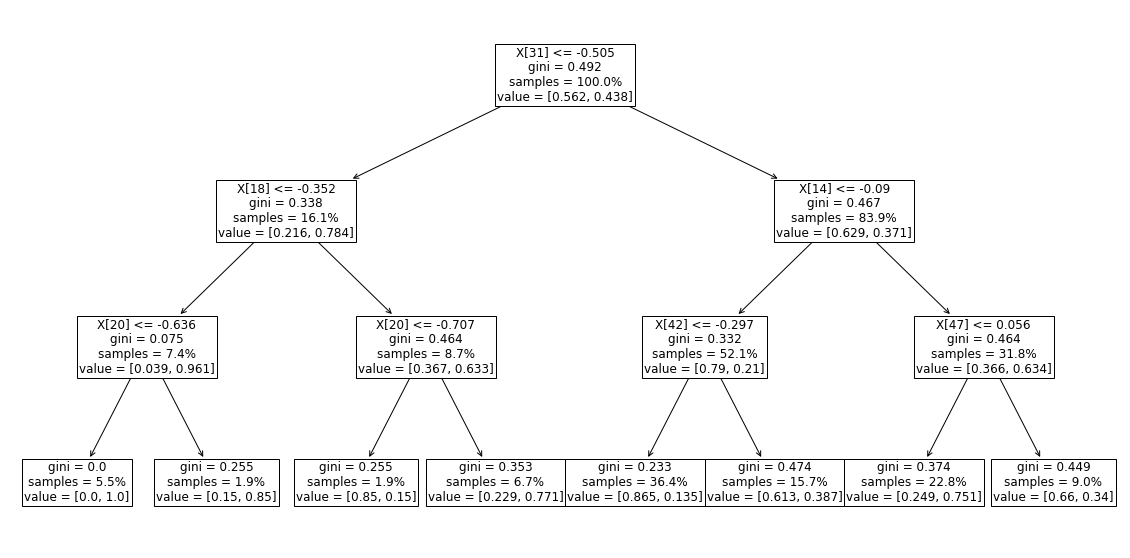

In [58]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf, proportion=True) 

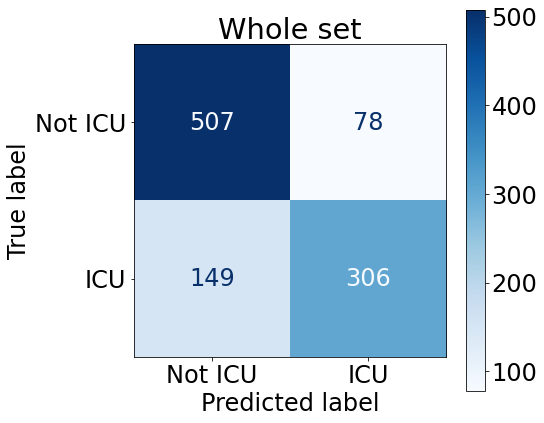

In [59]:
fig, ax = plt.subplots(figsize=(7,7))
plt.rcParams.update({'font.size': 24})

disp = plot_confusion_matrix(clf, features, Y,
                             display_labels=['Not ICU','ICU'],
                             cmap=plt.cm.Blues,
                             ax=ax)
disp.ax_.set_title('Whole set')

label_font = {'size':'24'}  # Adjust to fit
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);


### Cross-val

In [60]:
# cross-validation

from sklearn.model_selection import cross_val_score, cross_val_predict

cv_scores = cross_val_predict(clf, heatmaps_features_norm, Y, cv=400)

print(confusion_matrix(Y, cv_scores))
print(classification_report(Y, cv_scores))

[[458 127]
 [158 297]]
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76       585
         1.0       0.70      0.65      0.68       455

    accuracy                           0.73      1040
   macro avg       0.72      0.72      0.72      1040
weighted avg       0.72      0.73      0.72      1040



# BIMCV Pred

In [21]:
import pandas as pd

#metadata = pd.read_csv("../datasets/BIMCV-COVID19/BIMCV/derivatives/labels/labels_covid19_posi.tsv", sep='\t')
metadata = pd.read_csv("./output/bimcv_labels_covid19_posi.tsv", sep='\t')

In [22]:
data_test_name = "./output/bimcv_full_18feat.csv"

data_test = pd.read_csv(data_test_name)
data_test = data_test.iloc[:,1:].to_numpy()

print(data_test.shape)

(1312, 18)


In [23]:
data_test_norm = (data_test - data_test.mean(axis=0)) / data_test.std(axis=0)  
data_test_norm[np.isnan(data_test_norm)] = 0

In [24]:
#predict on test data

#RUN THE CLASSIFIER ON THE LAST LAYER FEATURES (FIRST SECTION) FIRST

y_pred = clf_18.predict(data_test_norm)

print('no_preds =', len(y_pred))
print('label 0 =', len([a for a in y_pred if a==0]))
print('label 1 =', len([a for a in y_pred if a==1]))

no_preds = 1312
label 0 = 806
label 1 = 506


In [25]:
output_pred_pth = './output/bim_predictions.txt'
output_pred_file = open(output_pred_pth,'w')


for y in y_pred:
    output_pred_file.write(str(int(y)))
    output_pred_file.write(',')
output_pred_file.close()

In [26]:
##ONLY EXECUTE WITH DATASET PRESENT

# list_of_imgs = os.listdir('../datasets/BIMCV-COVID19/BIMCV_processed/masked_filtered')

# output_features_names_pth = './output/bim_file_names.txt'
# file_features_names = open(output_features_names_pth,'w')


# for file_name in list_of_imgs:
#     file_features_names.write(file_name)
#     file_features_names.write(',')
# file_features_names.close()

In [28]:
# load name of files

file_name = 'bim_file_names.txt'

f = open(os.path.join('./output/',file_name), "r")
lst_of_files = f.read()
lst_of_files = lst_of_files.split(',')
lst_of_files = [i for i in lst_of_files[:-1]]

print('no of files =', len(lst_of_files))

no of files = 1312


In [29]:
# load predictions

file_name = 'bim_predictions.txt'

f = open(os.path.join('./output/',file_name), "r")
preds = f.read()
preds = preds.split(',')
preds = [int(i) for i in preds[:-1]]

print('no of predictions =', len(preds))

no of predictions = 1312


In [30]:
n_0 = len([a for a in preds if a==0])
n_1 = len([a for a in preds if a==1])

print('no_preds =', len(preds))
print('label 0 =', n_0)
print('label 1 =', n_1)

no_preds = 1312
label 0 = 806
label 1 = 506


In [38]:
#Get list with name of studies

pd.options.display.max_colwidth = 1000
lst_of_sess = []
for file_ in lst_of_files:
    idx = file_.find('ses-')
    lst_of_sess.append(file_[idx : idx+10])
    
column_ = 'Labels'#'Localizations'# 

In [39]:
#Example of filtering the data

import re

a = metadata.loc[metadata['ReportID'] == lst_of_sess[25]][column_]
a = a.to_string()

print(a)

a = re.findall(r'\w+', a) 
a = [i for i in a if not i.isdigit()]
a = [i for i in a if i!='t']
#a = [i.replace('t','') for i in a]

print(a)

230    ['COVID 19'\t ' increased density']
['COVID', 'increased', 'density']


In [40]:
dic_1 = {}

for n in range(len(lst_of_sess)):
    
    if preds[n]==1:
        a = metadata.loc[metadata['ReportID'] == lst_of_sess[n]][column_]
        a = a.to_string() 
        
        a = re.findall(r'\w+', a) 
        a = [i for i in a if not i.isdigit()]
        a = [i for i in a if i!='t']
        #a = [i.replace('t','') for i in a]
        
        for word in a:
            if word not in list(dic_1.keys()):
                dic_1[word] = 0
            else:
                dic_1[word] += 1
                
    
    

In [41]:
sort_orders_dic_1 = sorted(dic_1.items(), key=lambda x: x[1], reverse=True)

for i in sort_orders_dic_1:
    print(i[0], i[1] )

pattern 201
COVID 194
increased 137
density 137
pneumonia 131
unchanged 110
interstitial 96
infiltrates 80
alveolar 69
consolidation 65
normal 39
ground 34
glass 34
pleural 29
effusion 27
cardiomegaly 24
Series 24
aortic 19
atelectasis 18
costophrenic 16
angle 16
blunting 16
atypical 14
viral 14
tube 14
central 11
venous 11
catheter 11
heart 11
suboptimal 11
study 11
laminar 10
elongation 9
exclude 9
via 8
vein 8
bronchovascular 8
markings 8
changes 6
uncertain 6
hilar 6
chest 6
drain 6
jugular 5
artificial 5
valve 5
enlargement 5
endotracheal 5
insufficiency 5
thickening 4
reticular 4
pseudonodule 4
atheromatosis 4
chronic 3
scoliosis 3
apical 3
vertebral 3
congestion 3
air 2
bronchogram 2
mitral 2
degenerative 2
descendent 2
diaphragmatic 2
eventration 2
hemidiaphragm 2
elevation 2
metal 2
subclavian 2
pulmonary 2
emphysema 2
NaN 2
pneumothorax 2
NSG 1
sternotomy 1
granuloma 1
vascular 1
redistribution 1
material 1
azygos 1
lobe 1
mediastinal 1
calcified 1
fibrotic 1
band 1
volume 1


In [42]:
dic_0 = {}

for n in range(len(lst_of_sess)):
    
    if preds[n]==0:
        a = metadata.loc[metadata['ReportID'] == lst_of_sess[n]][column_]
        a = a.to_string() 
        
        a = re.findall(r'\w+', a) 
        a = [i for i in a if not i.isdigit()]
        a = [i for i in a if i!='t']
        #a = [i.replace('t','') for i in a]
        
        for word in a:
            if word not in list(dic_0.keys()):
                dic_0[word] = 0
            else:
                dic_0[word] += 1

    
                

In [43]:
sort_orders_dic_0 = sorted(dic_0.items(), key=lambda x: x[1], reverse=True)

for i in sort_orders_dic_1:
    for p in sort_orders_dic_0:
        if i[0] == p[0]:
            print(p[0] , p[1])

# for i in sort_orders:
#     print(i[0], i[1])

pattern 266
COVID 249
increased 231
density 231
pneumonia 170
unchanged 162
interstitial 127
infiltrates 104
alveolar 82
consolidation 62
normal 129
ground 55
glass 55
pleural 38
effusion 33
cardiomegaly 37
Series 47
aortic 34
atelectasis 37
costophrenic 15
angle 15
blunting 15
atypical 7
viral 15
tube 16
central 19
venous 18
catheter 18
heart 4
suboptimal 10
study 10
laminar 27
elongation 19
exclude 14
via 5
vein 5
bronchovascular 12
markings 12
changes 19
uncertain 10
hilar 11
chest 0
drain 0
jugular 4
artificial 1
valve 1
enlargement 12
endotracheal 9
insufficiency 2
thickening 8
reticular 10
pseudonodule 6
atheromatosis 12
chronic 5
scoliosis 0
apical 4
vertebral 15
congestion 0
air 3
bronchogram 2
mitral 0
degenerative 13
descendent 1
diaphragmatic 4
eventration 4
hemidiaphragm 4
elevation 4
metal 0
subclavian 0
pulmonary 5
emphysema 3
NaN 3
pneumothorax 1
NSG 3
sternotomy 5
granuloma 1
vascular 4
redistribution 0
material 4
azygos 1
lobe 1
mediastinal 0
calcified 4
fibrotic 4
ban

In [44]:
for i in sort_orders_dic_1:
    for p in sort_orders_dic_0:
        if i[0] == p[0]:
            if p[1] !=0:
                print(p[0], (i[1]/n_1)/(p[1]/n_0))

pattern 1.2036464679485275
COVID 1.2410432242805214
increased 0.9446982529986483
density 0.9446982529986483
pneumonia 1.2274587305277842
unchanged 1.0815888352120235
interstitial 1.2040708350191405
infiltrates 1.225296442687747
alveolar 1.3403547671840352
consolidation 1.6699604743083003
normal 0.4815699972423936
ground 0.984692777578153
glass 0.984692777578153
pleural 1.2156230497191596
effusion 1.3032698526769673
cardiomegaly 1.0332229462664244
Series 0.8133882768480363
aortic 0.8901418274819809
atelectasis 0.7749172096998184
costophrenic 1.6990777338603427
angle 1.6990777338603427
blunting 1.6990777338603427
atypical 3.185770750988142
viral 1.4866930171277999
tube 1.3937747035573123
central 0.9221967963386727
venous 0.9734299516908212
catheter 0.9734299516908212
heart 4.380434782608695
suboptimal 1.7521739130434781
study 1.7521739130434781
laminar 0.5899575464792857
elongation 0.7545246515498232
exclude 1.0239977413890458
via 2.5486166007905133
vein 2.5486166007905133
bronchovascula